# Modules installation

In [1]:
!pip install pyomo 
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



# Imports

In [2]:
from pyomo.environ import *
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dataset

Building a dataset from ground up with datasets function from sklearn module.

In [3]:
X, y = datasets.make_blobs(
      n_samples=100, n_features=2, centers=2, cluster_std=1.05, random_state=1
)

y = np.array([-1 if i==0 else i for i in y])

X_row, X_col = X.shape

## Dataset Information

In [4]:
print(f'- [X] Features: {X_row, X_col, type(X)}')
print(f'- [X] Labels: {y.shape, type(y)}')

- [X] Features: (100, 2, <class 'numpy.ndarray'>)
- [X] Labels: ((100,), <class 'numpy.ndarray'>)


## Dataset Distribution

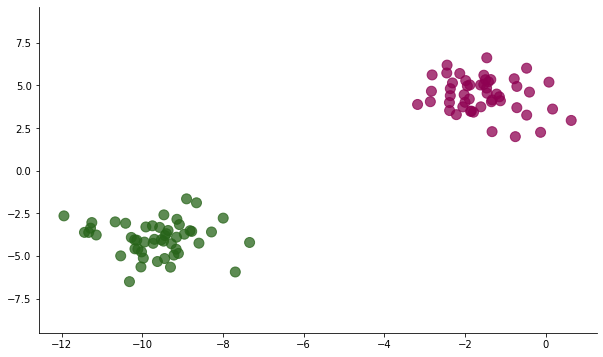

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

plt.set_cmap('PiYG')
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100, alpha=0.75)
x1_min = np.amin(X[:, 1])
x1_max = np.amax(X[:, 1])
ax.set_ylim([x1_min - 3, x1_max + 3])

for spine in ['top','right']:
    ax.spines[spine].set_visible(False)

plt.show()

## Pandas DataFrame

Storing the dataset as pandas dataframe gives us many functionalities which come in handy.

In [6]:
df = pd.DataFrame(X)
df['Y'] = pd.Series(y)

df.head()

,0,1,Y
0,-0.750882,1.989874,-1
1,-9.109244,-4.855840,1
2,-3.175879,3.876801,-1
3,-1.417960,5.206602,-1
4,-7.342971,-4.214415,1


# Abstract Model

In [42]:
model = AbstractModel()

## Range Sets

In [43]:
model.i = RangeSet(X_row)
model.j = RangeSet(1, X_col)

## Variables

In [44]:
model.W = Var(model.j, bounds=(-100, 100), within=Reals)
model.b = Var(bounds=(-100, 100), within=Reals)
model.eps = Var(model.i, bounds=(0, 2), initialize=0, within=NonNegativeReals)

## Parameters

### Labels

In [45]:
def inity(model, i):
  return df.loc[i-1, 'Y']

model.y = Param(model.i, initialize=inity, within=Reals, mutable=True)

### Features

In [46]:
def initx(model, i, j):
  return df.iloc[i-1, j-1]

model.x = Param(model.i, model.j, initialize=initx, within=Reals, mutable=True)

### C Constant


In [47]:
model.c = Param(initialize=100, within=Reals, mutable=False)

### Constraints

In [48]:
def rule_C1(model, i):
  return model.y[i]*(sum(model.W[j]*model.x[i, j] for j in model.j) + model.b) + model.eps[i] >= 1

model.C1 = Constraint(model.i, rule=rule_C1)

### Objective Function

In [49]:
def rule_OF(model):
  return sum(model.W[j]*model.W[j] for j in model.j) + model.c * sum(model.eps[i]*model.eps[i] for i in model.i)

model.obj1 = Objective(rule=rule_OF, sense=minimize)

### Display model

In [50]:
model.pprint()

1 Set Declarations
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :  200 : {(1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2), (4, 1), (4, 2), (5, 1), (5, 2), (6, 1), (6, 2), (7, 1), (7, 2), (8, 1), (8, 2), (9, 1), (9, 2), (10, 1), (10, 2), (11, 1), (11, 2), (12, 1), (12, 2), (13, 1), (13, 2), (14, 1), (14, 2), (15, 1), (15, 2), (16, 1), (16, 2), (17, 1), (17, 2), (18, 1), (18, 2), (19, 1), (19, 2), (20, 1), (20, 2), (21, 1), (21, 2), (22, 1), (22, 2), (23, 1), (23, 2), (24, 1), (24, 2), (25, 1), (25, 2), (26, 1), (26, 2), (27, 1), (27, 2), (28, 1), (28, 2), (29, 1), (29, 2), (30, 1), (30, 2), (31, 1), (31, 2), (32, 1), (32, 2), (33, 1), (33, 2), (34, 1), (34, 2), (35, 1), (35, 2), (36, 1), (36, 2), (37, 1), (37, 2), (38, 1), (38, 2), (39, 1), (39, 2), (40, 1), (40, 2), (41, 1), (41, 2), (42, 1), (42, 2), (43, 1), (43, 2), (44, 1), (44, 2), (45, 1), (45, 2), (46, 1), (46, 2), (47, 1), (47, 2), (48, 1), (48, 2), (

# Solver

In [51]:
opt = SolverFactory('ipopt', executable='/content/ipopt')
instance = model.create_instance()
results = opt.solve(instance).write()

instance.display()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 100
  Number of variables: 103
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.07780075073242188
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Mod

## Hyperplane

### Extracting Vars, Params

> Indented block



In [52]:
def var2np(var, name):
  return pd.Series(var.extract_values(), name=name).to_numpy()

#### Weights

In [53]:
W = var2np(instance.W, 'Weight')
W

array([-0.17320015, -0.18205158])

#### biases

In [54]:
b = var2np(instance.b, 'Bias')
b

array([-0.84396928])

#### Epsilons

In [55]:
eps = var2np(instance.eps, 'Eps')
eps

array([4.84945120e-06, 4.85916311e-06, 3.15818246e-04, 4.85783598e-06,
       4.87476072e-06, 4.85915543e-06, 4.85918616e-06, 4.85916811e-06,
       4.85621963e-06, 4.85729340e-06, 4.85933117e-06, 4.85801340e-06,
       4.85929956e-06, 4.85762840e-06, 4.85890278e-06, 4.85915601e-06,
       4.85930352e-06, 4.84349723e-06, 4.85560593e-06, 4.85941316e-06,
       4.85921388e-06, 4.85931937e-06, 4.85925220e-06, 4.85672037e-06,
       4.85188171e-06, 4.85935119e-06, 4.85923017e-06, 4.85647545e-06,
       4.85551193e-06, 4.85922295e-06, 4.85688645e-06, 4.84253991e-06,
       4.85936853e-06, 4.85151390e-06, 4.85835403e-06, 4.85930738e-06,
       4.85824949e-06, 4.85944373e-06, 4.85930901e-06, 4.85930142e-06,
       4.85925433e-06, 4.85925742e-06, 4.85401722e-06, 4.85942965e-06,
       4.85709223e-06, 4.85921885e-06, 4.85822015e-06, 4.85801200e-06,
       4.85215743e-06, 4.85179602e-06, 4.85526567e-06, 4.85922482e-06,
       4.85932230e-06, 4.85939060e-06, 4.85758481e-06, 4.85921997e-06,
      

#### X

#### Building Hyper Plane

In [56]:
def get_hyperplane(x, w, b, offset):
  return (-w[0] * x - b + offset) / w[1]

-11.948593461322192 0.6352942709113001 6.731767311367792 -5.240286078067647
12.224716175677495 0.2526627862420566 1.2388184470580887 -10.73323494237735


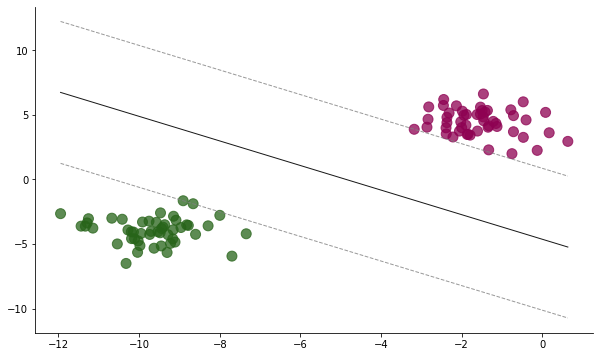

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

plt.set_cmap('PiYG')
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100, alpha=0.75)

x0_1 = np.amin(X[:, 0])
x0_2 = np.amax(X[:, 0])

x1_1 = get_hyperplane(x0_1, W, b, 0)[0]
x1_2 = get_hyperplane(x0_2, W, b, 0)[0]

x1_1_m = get_hyperplane(x0_1, W, b, -1)[0]
x1_2_m = get_hyperplane(x0_2, W, b, -1)[0]

x1_1_p = get_hyperplane(x0_1, W, b, 1)[0]
x1_2_p = get_hyperplane(x0_2, W, b, 1)[0]

print(x0_1, x0_2, x1_1, x1_2)
print(x1_1_m, x1_2_m, x1_1_p, x1_2_p)

ax.plot([x0_1, x0_2], [x1_1, x1_2], "-", c='k', lw=1, alpha=0.9)
ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "--", c='grey', lw=1, alpha=0.8)
ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "--", c='grey', lw=1, alpha=0.8)

def plt_lim():
  x1_min = np.amin(X[:, 1])
  x1_max = np.amax(X[:, 1])
  ax.set_ylim([x1_min - 3, x1_max + 3])

# plt_lim()

for spine in ['top','right']:
    ax.spines[spine].set_visible(False)

plt.show()